In [1]:
from qiskit import IBMQ, QuantumCircuit, Aer, execute,transpile
from qiskit.quantum_info import Statevector, Operator
import math
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_state_qsphere, plot_distribution
from IPython.display import Markdown, HTML
import matplotlib.pyplot as plt

import os
from dotenv import load_dotenv

load_dotenv()

IBMQ_API_TOKEN = os.getenv('IBMQ_API_TOKEN')

IBMQ.save_account(IBMQ_API_TOKEN, overwrite=True)
IBMQ.load_account()



C:\Users\ekara\AppData\Local\Temp\ipykernel_29988\2386640195.py:15: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.save_account(IBMQ_API_TOKEN, overwrite=True)
C:\Users\ekara\AppData\Local\Temp\ipykernel_29988\2386640195.py:15: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.save_account(IBMQ_API_TOKEN, overwrite=True)


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
def apply_n_hgates(qc, n):
    qc.h(range(n))
    return qc

def init_n_qubit_circuit(n):
    qc=QuantumCircuit(n,n)
    return qc

def grovers_algorithm(n, solutions, iterations):
    # Initialize the quantum circuit
    qc = init_n_qubit_circuit(n)
    qc.barrier(label="init")

    # Apply Hadamard gates to all qubits to create a superposition
    qc = apply_n_hgates(qc, n)
    
    # Apply the oracle and the diffuser multiple times
    for i in range(iterations):
        # Multi-target oracle
        oracle_circuit = multi_target_oracle(n, solutions)
        qc.barrier(label=f"O_{i+1}")
        qc = qc.compose(oracle_circuit)

        
        # Diffuser
        diffuser_circuit = diffuser(n)
        qc.barrier(label=f"D_{i+1}")
        qc = qc.compose(diffuser_circuit)
    qc.measure(range(n), range(n))
    return qc


def multi_target_oracle(n, solutions):
    oracle = QuantumCircuit(n)
    for solution in solutions:
        # Apply X gates to match the '0' in the solution
        for qubit in range(n):
            if solution[n-1-qubit] == '0':
                oracle.x(qubit)

        # Apply Controlled-Z
        oracle.h(0)  # Apply Hadamard to the target qubit
        oracle.mcx(list(range(1, n)), 0)  # Control on all higher bits, target is 0
        oracle.h(0)

        # Uncompute (cleanup X gates)
        for qubit in range(n):
            if solution[n-1-qubit] == '0':
                oracle.x(qubit)

    return oracle

def diffuser(n):
    qc = QuantumCircuit(n)
    
    # Apply Hadamard gates to all qubits
    qc.h(range(n))
    # Apply Pauli-X gates to all qubits
    qc.x(range(n))
    # Apply a multi-controlled-Z gate
    # First, apply Hadamard to the target qubit
    qc.h(n-1)
    # Apply the multi-controlled-X gate (acting as a multi-controlled-Z)
    # which controls are on all other qubits and target is the last qubit
    qc.mcx(list(range(n-1)), n-1)
    # Apply Hadamard again to the target qubit
    qc.h(n-1)
    # Apply Pauli-X gates to all qubits again
    qc.x(range(n))
    # Apply Hadamard gates to all qubits to finish
    qc.h(range(n))

    return qc

In [3]:
provider = IBMQ.get_provider('ibm-q')
backend = provider.get_backend('ibm_sherbrooke')  # Replace with your backend


In [4]:
n = 5  # Number of qubits
solutions = ['11111']
iterations = math.floor((math.pi/4)*(math.sqrt((2**n)/(len(solutions)))))

In [5]:
n = 5  # Number of qubits
solutions = ['11111']
iterations = math.floor((math.pi/4)*(math.sqrt((2**n)/(len(solutions)))))
grover_circuit = grovers_algorithm(n, solutions, iterations)

init ┌───┐ O_1 ┌───┐┌───┐┌───┐ D_1 ┌───┐┌───┐          ┌───┐┌───┐     »
q_0: ──░───┤ H ├──░──┤ H ├┤ X ├┤ H ├──░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────»
       ░   ├───┤  ░  └───┘└─┬─┘└───┘  ░  ├───┤├───┤       │  ├───┤├───┤     »
q_1: ──░───┤ H ├──░─────────■─────────░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────»
       ░   ├───┤  ░         │         ░  ├───┤├───┤       │  ├───┤├───┤     »
q_2: ──░───┤ H ├──░─────────■─────────░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────»
       ░   ├───┤  ░         │         ░  ├───┤├───┤       │  ├───┤├───┤     »
q_3: ──░───┤ H ├──░─────────■─────────░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────»
       ░   ├───┤  ░         │         ░  ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐»
q_4: ──░───┤ H ├──░─────────■─────────░──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├»
       ░   └───┘  ░                   ░  └───┘└───┘└───┘└───┘└───┘└───┘└───┘»
c: 5/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«      O_2 ┌───┐┌───┐┌───┐ D_2 ┌───┐┌───┐          ┌───┐┌───┐      O_3 ┌───┐»
«q_0: ──░──┤ H ├┤ X ├┤ H ├──░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────░──┤ H ├»
«       ░  └───┘└─┬─┘└───┘  ░  ├───┤├───┤       │  ├───┤├───┤       ░  └───┘»
«q_1: ──░─────────■─────────░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────░───────»
«       ░         │         ░  ├───┤├───┤       │  ├───┤├───┤       ░       »
«q_2: ──░─────────■─────────░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────░───────»
«       ░         │         ░  ├───┤├───┤       │  ├───┤├───┤       ░       »
«q_3: ──░─────────■─────────░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────░───────»
«       ░         │         ░  ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐  ░       »
«q_4: ──░─────────■─────────░──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├──░───────»
«       ░                   ░  └───┘└───┘└───┘└───┘└───┘└───┘└───┘  ░       »
«c: 5/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«     ┌───┐┌───┐ D_3 ┌───┐┌───┐          ┌───┐┌───┐      O_4 ┌───┐┌───┐┌───┐»
«q_0: ┤ X ├┤ H ├──░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────░──┤ H ├┤ X ├┤ H ├»
«     └─┬─┘└───┘  ░  ├───┤├───┤       │  ├───┤├───┤       ░  └───┘└─┬─┘└───┘»
«q_1: ──■─────────░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────░─────────■───────»
«       │         ░  ├───┤├───┤       │  ├───┤├───┤       ░         │       »
«q_2: ──■─────────░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────░─────────■───────»
«       │         ░  ├───┤├───┤       │  ├───┤├───┤       ░         │       »
«q_3: ──■─────────░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────░─────────■───────»
«       │         ░  ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐  ░         │       »
«q_4: ──■─────────░──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├──░─────────■───────»
«                 ░  └───┘└───┘└───┘└───┘└───┘└───┘└───┘  ░                 »
«c: 5/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«      D_4 ┌───┐┌───┐          ┌───┐┌───┐     ┌─┐            
«q_0: ──░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────┤M├────────────
«       ░  ├───┤├───┤       │  ├───┤├───┤     └╥┘┌─┐         
«q_1: ──░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────╫─┤M├─────────
«       ░  ├───┤├───┤       │  ├───┤├───┤      ║ └╥┘┌─┐      
«q_2: ──░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────╫──╫─┤M├──────
«       ░  ├───┤├───┤       │  ├───┤├───┤      ║  ║ └╥┘┌─┐   
«q_3: ──░──┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────╫──╫──╫─┤M├───
«       ░  ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ║  ║  ║ └╥┘┌─┐
«q_4: ──░──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─╫──╫──╫──╫─┤M├
«       ░  └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ║  ║  ║  ║ └╥┘
«c: 5/═════════════════════════════════════════╩══╩══╩══╩══╩═
«                                              0  1  2  3  4

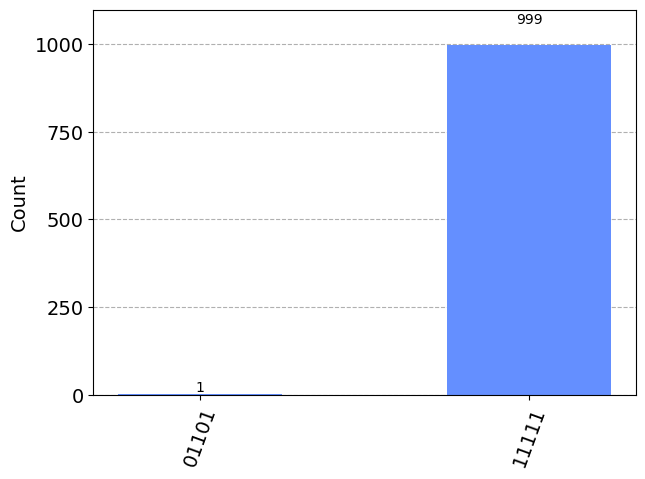

In [32]:
sim = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(grover_circuit, backend=sim, optimization_level=1)
display(compiled_circuit.draw())

# Execute the circuit
job = sim.run(compiled_circuit, shots=1000)
result = job.result()

# Obtain and plot the counts
counts = result.get_counts()
display(plot_histogram(counts))

In [6]:
transpiled_qc = transpile(grover_circuit, backend=backend, optimization_level=3)
print(transpiled_qc.count_ops())


OrderedDict([('rz', 2262), ('sx', 1413), ('ecr', 505), ('x', 75), ('barrier', 10), ('measure', 5)])


In [ ]:
job = backend.run(transpiled_qc, shots=1000)
result = job.result()  # Fetch results
counts = result.get_counts(grover_circuit)  # Get the count of each measurement result
display(plot_histogram(counts))

C:\Users\ekara\AppData\Local\Temp\ipykernel_2320\1439245971.py:126: DeprecationWarning: The 'qiskit.Aer' entry point is deprecated and will be removed in Qiskit 1.0. You should use 'qiskit_aer.Aer' directly instead.
  sim = Aer.get_backend('qasm_simulator')


init           ┌───┐ O_1  D_1  O_2  D_2  O_3  D_3  O_4  D_4 ┌─┐      »
 q913_0: ──░─────■────■──┤ H ├──░────░────░────░────░────░────░────░──┤M├──────»
           ░   ┌─┴─┐  │  └───┘  ░    ░    ░    ░    ░    ░    ░    ░  └╥┘      »
 q913_1: ──░───┤ X ├──┼─────────░────░────░────░────░────░────░────░───╫───────»
           ░   └───┘┌─┴─┐       ░    ░    ░    ░    ░    ░    ░    ░   ║       »
 q913_2: ──░────────┤ X ├───────░────░────░────░────░────░────░────░───╫───────»
           ░        └───┘┌───┐  ░    ░    ░    ░    ░    ░    ░    ░   ║ ┌─┐   »
 q913_3: ──░─────■────■──┤ H ├──░────░────░────░────░────░────░────░───╫─┤M├───»
           ░   ┌─┴─┐  │  └───┘  ░    ░    ░    ░    ░    ░    ░    ░   ║ └╥┘   »
 q913_4: ──░───┤ X ├──┼─────────░────░────░────░────░────░────░────░───╫──╫────»
           ░   └───┘┌─┴─┐       ░    ░    ░    ░    ░    ░    ░    ░   ║  ║    »
 q913_5: ──░────────┤ X ├───────░────░────░────░────░────░────░────░───╫──╫────»
           ░        └───┘┌───┐  ░    ░    ░    ░    ░    ░    ░    ░   ║  ║ ┌─┐»
 q913_6: ──░─────■────■──┤ H ├──░────░────░────░────░────░────░────░───╫──╫─┤M├»
           ░   ┌─┴─┐  │  └───┘  ░    ░    ░    ░    ░    ░    ░    ░   ║  ║ └╥┘»
 q913_7: ──░───┤ X ├──┼─────────░────░────░────░────░────░────░────░───╫──╫──╫─»
           ░   └───┘┌─┴─┐       ░    ░    ░    ░    ░    ░    ░    ░   ║  ║  ║ »
 q913_8: ──░────────┤ X ├───────░────░────░────░────░────░────░────░───╫──╫──╫─»
           ░        └───┘┌───┐  ░    ░    ░    ░    ░    ░    ░    ░   ║  ║  ║ »
 q913_9: ──░─────■────■──┤ H ├──░────░────░────░────░────░────░────░───╫──╫──╫─»
           ░   ┌─┴─┐  │  └───┘  ░    ░    ░    ░    ░    ░    ░    ░   ║  ║  ║ »
q913_10: ──░───┤ X ├──┼─────────░────░────░────░────░────░────░────░───╫──╫──╫─»
           ░   └───┘┌─┴─┐       ░    ░    ░    ░    ░    ░    ░    ░   ║  ║  ║ »
q913_11: ──░────────┤ X ├───────░────░────░────░────░────░────░────░───╫──╫──╫─»
           ░        └───┘┌───┐  ░    ░    ░    ░    ░    ░    ░    ░   ║  ║  ║ »
q913_12: ──░─────■────■──┤ H ├──░────░────░────░────░────░────░────░───╫──╫──╫─»
           ░   ┌─┴─┐  │  └───┘  ░    ░    ░    ░    ░    ░    ░    ░   ║  ║  ║ »
q913_13: ──░───┤ X ├──┼─────────░────░────░────░────░────░────░────░───╫──╫──╫─»
           ░   └───┘┌─┴─┐       ░    ░    ░    ░    ░    ░    ░    ░   ║  ║  ║ »
q913_14: ──░────────┤ X ├───────░────░────░────░────░────░────░────░───╫──╫──╫─»
           ░        └───┘       ░    ░    ░    ░    ░    ░    ░    ░   ║  ║  ║ »
q913_15: ──░────────────────────░────░────░────░────░────░────░────░───╫──╫──╫─»
           ░                    ░    ░    ░    ░    ░    ░    ░    ░   ║  ║  ║ »
  c21: 5/══════════════════════════════════════════════════════════════╩══╩══╩═»
                                                                       0  1  2 »
«               
« q913_0: ──────
«               
« q913_1: ──────
«               
« q913_2: ──────
«               
« q913_3: ──────
«               
« q913_4: ──────
«               
« q913_5: ──────
«               
« q913_6: ──────
«               
« q913_7: ──────
«               
« q913_8: ──────
«         ┌─┐   
« q913_9: ┤M├───
«         └╥┘   
«q913_10: ─╫────
«          ║    
«q913_11: ─╫────
«          ║ ┌─┐
«q913_12: ─╫─┤M├
«          ║ └╥┘
«q913_13: ─╫──╫─
«          ║  ║ 
«q913_14: ─╫──╫─
«          ║  ║ 
«q913_15: ─╫──╫─
«          ║  ║ 
«  c21: 5/═╩══╩═
«          3  4

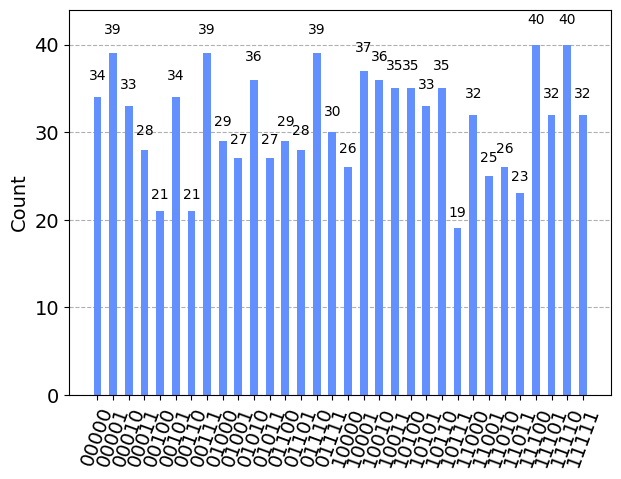

In [28]:
def encode_bit_flip(qc, start_idx):
    """Encodes a logical qubit into three physical qubits using a bit-flip code."""
    qc.cx(start_idx, start_idx + 1)
    qc.cx(start_idx, start_idx + 2)

def syndrome_measurement(qc, qubits, ancilla):
    qc.cx(qubits[0], ancilla)
    qc.cx(qubits[1], ancilla)
    qc.cx(qubits[1], ancilla)
    qc.cx(qubits[2], ancilla)
    qc.measure(ancilla, 0)  # Assuming a classical bit is allocated for this purpose

def apply_correction(qc, qubits, cbit):
    qc.x(qubits[0]).c_if(cbit, 1)
    
def diffuser_with_qec(n):
    logical_qubits = n
    physical_qubits = 3 * n + 1  # 3 per logical qubit + 1 ancilla for syndrome measurement
    qr = QuantumRegister(physical_qubits)
    cr = ClassicalRegister(1)  # One classical register for measurement of the ancilla
    diffuser = QuantumCircuit(qr, cr)

    # Apply Hadamard and Pauli-X gates to all logical qubits (on representative qubit only)
    for i in range(logical_qubits):
        diffuser.h(qr[3*i])
        diffuser.x(qr[3*i])

    # Apply syndrome measurement and correction
    for i in range(logical_qubits):
        syndrome_measurement(diffuser, [3*i, 3*i+1, 3*i+2], physical_qubits-1)
        apply_correction(diffuser, [3*i, 3*i+1, 3*i+2], cr[0])

    # Apply a multi-controlled-Z gate across all logical qubits (using representative qubits)
    controls = [qr[3*i] for i in range(logical_qubits-1)]
    target = qr[3*(logical_qubits-1)]
    diffuser.h(target)  # Apply Hadamard to the target logical qubit
    diffuser.mcx(controls, target)  # Multi-controlled NOT as a Z gate
    diffuser.h(target)  # Apply Hadamard again

    # Reapply syndrome measurement and correction
    for i in range(logical_qubits):
        syndrome_measurement(diffuser, [3*i, 3*i+1, 3*i+2], physical_qubits-1)
        apply_correction(diffuser, [3*i, 3*i+1, 3*i+2], cr[0])

    # Reverse the initial operations: Apply X and Hadamard to all logical qubits (on representative qubit only)
    for i in range(logical_qubits):
        diffuser.x(qr[3*i])
        diffuser.h(qr[3*i])

    return diffuser

    
def multi_target_oracle_with_qec(n, solutions):
    # Create quantum registers: one for each physical qubit of each logical qubit (3 per logical qubit) and one ancilla for syndrome measurement
    qr = QuantumRegister(3*n + 1)
    cr = ClassicalRegister(1)  # Classical register for storing the measurement result of the ancilla
    qc = QuantumCircuit(qr, cr)

    # Correctly encode each logical qubit
    for i in range(n):
        encode_bit_flip(qc, 3*i)  # Pass each starting index of the triplet to the encode function

    for solution in solutions:
        for qubit in range(n):
            if solution[n-1-qubit] == '0':
                qc.x(qr[3*qubit])

        # Apply syndrome measurement and error correction
        for i in range(n):
            syndrome_measurement(qc, [3*i, 3*i+1, 3*i+2], 3*n)
            apply_correction(qc, [3*i, 3*i+1, 3*i+2], cr[0])

        # Controlled operations
        qc.h(qr[0])
        qc.mcx([qr[3*i] for i in range(1, n)], qr[0])
        qc.h(qr[0])

        # Cleanup X gates based on the solution
        for qubit in range(n):
            if solution[n-1-qubit] == '0':
                qc.x(qr[3*qubit])

    return qc


def grovers_algorithm_with_qec(n, solutions, iterations):
    logical_qubits = n
    physical_qubits = 3 * n + 1  # 3 per logical qubit + 1 ancilla for syndrome measurements
    qr = QuantumRegister(physical_qubits)
    cr = ClassicalRegister(logical_qubits)  # One classical bit per logical qubit
    qc = QuantumCircuit(qr, cr)
    
    qc.barrier(label="init")

    # Encode each logical qubit and apply Hadamard gates to each logical qubit
    for i in range(logical_qubits):
        encode_bit_flip(qc, 3*i)
        qc.h(qr[3*i])  # Apply Hadamard to just the first of the three qubits representing each logical qubit

    # Apply the QEC-enhanced oracle and diffuser multiple times
    for i in range(iterations):
        oracle_circuit = multi_target_oracle_with_qec(logical_qubits, solutions)
        qc.barrier(label=f"O_{i+1}")
        qc.compose(oracle_circuit, range(physical_qubits))

        diffuser_circuit = diffuser_with_qec(logical_qubits)
        qc.barrier(label=f"D_{i+1}")
        qc.compose(diffuser_circuit, range(physical_qubits))

    # Measure only the first of every three qubits which represent each logical qubit
    for i in range(logical_qubits):
        qc.measure(qr[3*i], cr[i])  # Corrected measure indexing

    return qc



# Define number of logical qubits and prepare parameters
n = 5  # Number of logical qubits
solutions = ['11111']
iterations = math.floor((math.pi / 4) * math.sqrt((2 ** n) / len(solutions)))

# Create and run the quantum circuit with QEC
grover_circuit_with_qec = grovers_algorithm_with_qec(n, solutions, iterations)

sim = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(grover_circuit_with_qec, backend=sim, optimization_level=1)
display(compiled_circuit.draw())

# Execute the circuit
job = sim.run(compiled_circuit, shots=1000)
result = job.result()

# Obtain and plot the counts
counts = result.get_counts()
display(plot_histogram(counts))